In [1]:
import numpy as np
import scipy.stats as sps
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams.update({'figure.figsize': (10.0, 6.0), 'font.size': 18})
t = np.linspace(-10,10,1000) # x-axis for our plots

## Bayesian inference for Gaussian distribution


Gaussian distribution parametrized by mean $\mu$ and precision $\lambda = \frac{1}{\sigma^2}$ rather than variance $\sigma^2$
$$
\DeclareMathOperator{\NormalGamma}{NormalGamma}
\DeclareMathOperator{\Norm}{\mathcal{N}}
\DeclareMathOperator{\Gam}{Gam}
\DeclareMathOperator{\e}{exp}
\large
p(x | \mu, \lambda) = \Norm(x \mid \mu, \lambda^{-1}) = \frac{\sqrt{\lambda}}{\sqrt{2\pi}} \e\{ \frac{-\lambda(x - \mu)^2}{2}\}
$$

NormalGamma distribution can be used as the conjugate prior over the mean $\mu$ and precision $\lambda$ parameters of Gaussian distribution.

$$
\large
\NormalGamma(\mu,\lambda|m,\kappa,a,b) = \Norm(\mu|m,(\kappa\lambda)^{-1}) \Gam(\lambda|a,b)
$$

where gamma distribution

$$
\large
\Gam(\lambda \mid a, b) = \frac{1}{\Gamma(a)} b^a \lambda^{a - 1} \e \{ -b \lambda\}
$$



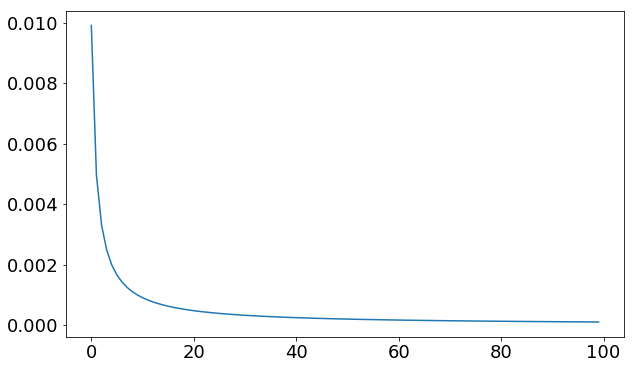

In [2]:
plt.plot(sps.gamma.pdf(np.linspace(0.1, 10, 100), 0.001, scale=1.0/0.001))


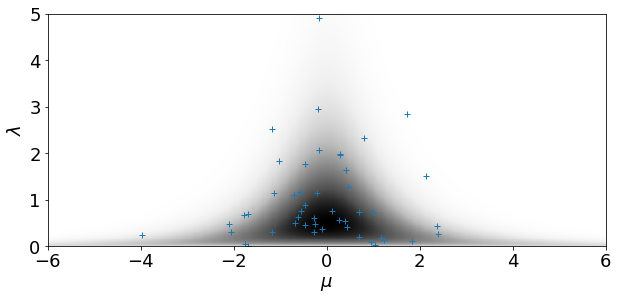

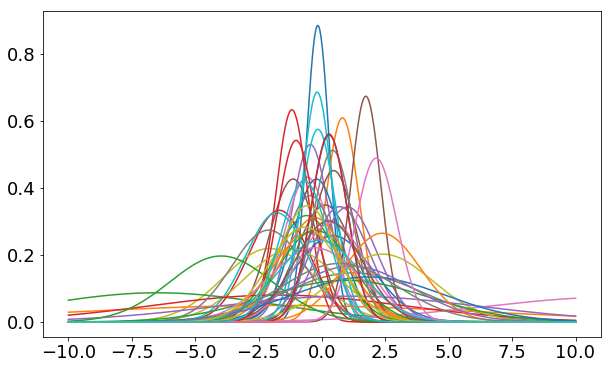

In [3]:
def NormalGamma_pdf(mu, lmbd, m, kappa, a, b):
    # sps.norm.pdf takes mean and std (not variance), therefore 1.0/
    # sps.gamma.pdf takes shape and scale (not rate), therefore 1.0/b
    return sps.norm.pdf(mu, m, 1.0/np.sqrt(lmbd*kappa))* sps.gamma.pdf(lmbd, a, scale=1.0/b)

def NormalGamma_rvs(m, kappa, a, b, N):
    # Sample from NormalGamma distribution
    lmbd = sps.gamma.rvs(a, scale=1.0/b, size=N)
    mu = sps.norm.rvs(m, 1.0/np.sqrt(lmbd*kappa), N)
    return mu, lmbd

def NormalGamma_plot(m0, kappa0, a0, b0, limits):
   mu_vals, lmbd_vals = np.meshgrid(np.linspace(limits[0], limits[1], 500), np.linspace(limits[2], limits[3], 500))
   pdf = NormalGamma_pdf(mu_vals, lmbd_vals, m0, kappa0, a0, b0)
   plt.imshow(pdf, origin='lower', cmap='Greys', extent=limits)
   plt.xlabel('$\mu$'); plt.ylabel('$\lambda$')


#Plot some example NormalGamma distribution
m0, kappa0, a0, b0 = 0.0, 1.0, 1.0, 1.0
plot_limits=[-6, 6, 0.01, 5]
NormalGamma_plot(m0, kappa0, a0, b0, limits=plot_limits)

# Obtain few samples from the prior distribution.
mu_sampled, lmbd_sampled = NormalGamma_rvs(m0, kappa0, a0, b0, 50)
plt.plot(mu_sampled, lmbd_sampled, '+'); plt.axis(plot_limits)

# Each of these sample represents mean and precision. Plot the corresponding Gaussian distributions
plt.figure()
plt.plot(t, sps.norm.pdf(t[:,np.newaxis], mu_sampled, 1/np.sqrt(lmbd_sampled)));

Given $N$ observations $\mathbf{x}=[x_1, x_2, \dots, x_N]$ from gaussian distribution $\Norm(x \mid \mu, \lambda^{-1})$ and given prior $p(\mu, \lambda^{-1}) = \NormalGamma(\mu,\lambda|m_0,\kappa_0,a_0,b_0)$ the poterior distribution over the Gaussian parameters is:

$$
\large
p(\mu, \lambda^{-1}|\mathbf{x}) = \NormalGamma(\mu,\lambda|m_N,\kappa_N,a_N,b_N)
$$, 

where


$$
\large
\begin{align}
m_N &= \frac{\kappa_0 m_0 + N \bar{x}} {\kappa_0 +  N} \\
\kappa_N &= \kappa_0 + N \\
a_N &= a_0 + \frac{N}{2} \\
b_N &= b_0 + \frac{N}{2} ( s + \frac{\kappa_0 (\bar{x} - m_0)^2}{\kappa_0 + N} ) \\
\bar{x} &= \frac{1}{N} \sum_i x_i \\
s &= \frac{1}{N} \sum_i (x_i - \bar{x})^2
\end{align}
$$

Note that the prior parameters can be interpreted as follows:
* $2a_0$ - prior number of observation for precision (or variance)
* $b_0/a_0$ - prior variance (around $m_0$)
* $\kappa_0$ - number of prior observations for mean
* $m_0$ - prior mean

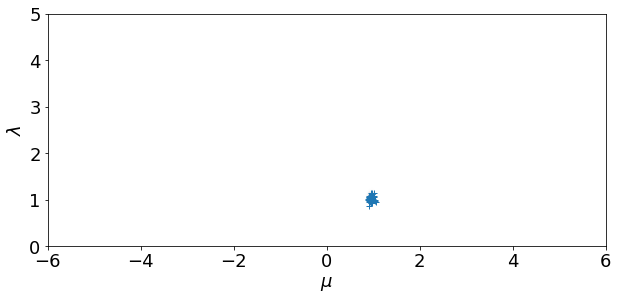

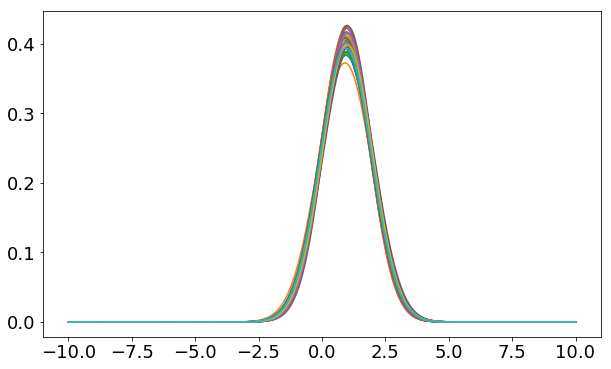

In [4]:
def NormalGammaPosteriorParams(m0, kappa0, a0, b0, x):
  # given prior parameters m0, kappa0, a0, b0 and observations x
  # sufficient statistics N, mean, var calculate parameters of posterior
  N = len(x)
  mean = np.mean(x)
  var = np.var(x)

  kappaN = kappa0 + N
  mN = (kappa0*m0 + mean*N) / kappaN;
  aN = a0 + 0.5*N;
  bN = b0 + 0.5 * N * (var + kappa0*(mean-m0)**2/(kappa0 + N))
  return mN, kappaN, aN, bN

def NormalGammaPosteriorParams2(m0, kappa0, a0, b0, x):
  # alternative more practical implementation, which does not crash for N=0
  N = len(x)
  f = np.sum(x)
  s = np.sum(x**2)

  kappaN = kappa0 + N
  mN = (kappa0*m0 + f) / kappaN;
  aN = a0 + 0.5*N;
  bN  = b0 + 0.5 * (s + kappa0 * m0**2 - kappaN * mN**2);
  return mN, kappaN, aN, bN


# Generate observation from agiven Gaussian distribution 
N = 500
mu = 1.0    # mean
sigma = 1 # standard deviation (std)
x = sps.norm.rvs(mu, sigma, N)

# Given NormalGamma prior and the observation, calculate and plot posterior distibution of the Gaussian parameters
mN, kappaN, aN, bN = NormalGammaPosteriorParams2(m0, kappa0, a0, b0, x)
NormalGamma_plot(mN, kappaN, aN, bN, limits=plot_limits)

# Obtain few samples from the posterior distribution.
mu_sampled, lmbd_sampled = NormalGamma_rvs(mN, kappaN, aN, bN, 50)
plt.plot(mu_sampled, lmbd_sampled, '+'); plt.axis(plot_limits)

# Each of these sample represents mean and precision. Plot the corresponding Gaussian distributions
pdfs_sampled = sps.norm.pdf(t[:,np.newaxis], mu_sampled, 1/np.sqrt(lmbd_sampled))
plt.figure()
plt.plot(t, pdfs_sampled);

### Predictive probability

For the Gaussian with NormalGamma prior, the posterior predictive distribution is the Student's t-distribution:

$$
\large
\newcommand{\diff}{\mathop{}\!d}
\DeclareMathOperator{\St}{\mathcal{St}}
\begin{align}
p(x' \mid \mathbf{x}) 
&= \int_{-\infty}^{\infty} p(x'|\mu, \lambda) p(\mu, \lambda \mid \mathbf{x}) \diff \mu \diff \lambda \\
&= \int_{-\infty}^{\infty} \Norm(x'|\mu, \lambda) \NormalGamma(\mu,\lambda|m_0,\kappa_0,a_0,b_0) \diff \mu \diff \lambda \\ 
&= \St(x' \mid m_N, 2a_N, \frac{a_N \kappa_N}{b_N(\kappa_N + 1)} )
\end{align}
$$

where:

$$
\large
\St(x' \mid \mu, \nu, \gamma) = \frac{\Gamma(\frac{\nu}{2} + \frac{1}{2})}{\Gamma(\frac{\nu}{2})} \Big( \frac{\gamma}{\pi \nu} \Big)^{\frac{1}{2}} \Big[ 1 + \frac{\gamma (x - \mu)^2}{\nu} \Big]^{-\frac{\nu}{2} - \frac{1}{2}}
$$


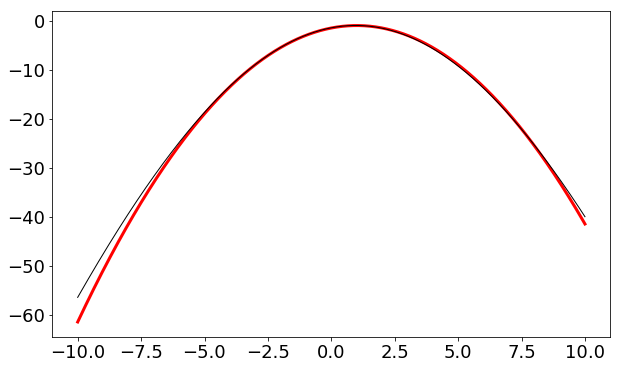

In [6]:
# Plot the distribution from which the observations were generated
plt.plot(t, np.log(sps.norm.pdf(t, mu, sigma)), 'r',lw=3)

# Plot predictive distribution, which depends on the prior and the observations 
# (i.e. depends on the posterior distribution over the parameters \mu and \lambda)
plt.plot(t, np.log(sps.t.pdf(t, loc=mN, df=2*aN, scale=np.sqrt(bN*(kappaN+1)/aN/kappaN))), 'k',lw=1)

# Take all the sampled Gaussian distributions from the previous figure, average them and plot the resulting distribution
# For large number of samples, this should be good approximation to the predictive distribution 
#plt.plot(t, pdfs_sampled.mean(axis=1));